## Logistic Regression Experiments

### Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib

In [2]:
random.seed(42)
np.random.seed(42)

- Load the train and test files 

In [3]:
train_df = pd.read_csv("train_data.csv")
val_df  = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

In [4]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## TF-IDF - Experiment 6 (Additional Preprocessing Steps in Experiment 5 + Stopword Removal)

In [5]:
import nltk
import re, ftfy, string
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))
punct_table = str.maketrans('', '', string.punctuation)

- Text preprocessing steps

In [6]:
def clean_text_pipeline(text):
    # Fix Unicode glitches
    text = ftfy.fix_text(text)

    # Strip HTML tags and URLs
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Strip non-ASCII (e.g. Äô,â€)
    text = re.sub(r'[^\x20-\x7E]', ' ', text)

    # Lowercase 
    text = text.lower()

    # Remove Punctuation 
    text = text.translate(punct_table)

    # Remove whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Split into words for stopword removal (next step)
    words = text.split() 

    # Drop stopwords
    words = [w for w in words if w not in stopwords.words('english')]

    return " ".join(words)

In [7]:
train_df["clean_text"] = train_df["text"].astype(str).apply(clean_text_pipeline)
val_df["clean_text"]   = val_df["text"].astype(str).apply(clean_text_pipeline)
train_texts = train_df["clean_text"]
val_texts   = val_df["clean_text"]

y_train     = train_df["sentiment_id"]
y_val       = val_df["sentiment_id"]

In [8]:
def tfidf(train_texts, val_texts):
    vec = TfidfVectorizer()        #tokenization and vectorization
    X_train = vec.fit_transform(train_texts)
    X_val   = vec.transform(val_texts)
    return X_train, X_val

- Hyperparameter tuning

In [9]:
def objective(trial):
    # TF–IDF hyperparameters
    max_df       = trial.suggest_float("max_df", 0.5, 1.0)
    min_df       = trial.suggest_int("min_df", 1, 5)
    ngram_max    = trial.suggest_int("ngram_max", 1, 2)
    max_features = trial.suggest_int("max_features", 1_000, 20_000, step=1_000)

    vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=min_df,
        ngram_range=(1, ngram_max),
        max_features=max_features
    )
    X_tr = vectorizer.fit_transform(train_texts)
    X_va = vectorizer.transform(val_texts)

    # LogisticRegression hyperparameters
    C     = trial.suggest_float("C", 1e-3, 1e3, log=True)
    combo = trial.suggest_categorical(
        "penalty_solver",
        ["l1_saga", "l2_lbfgs", "l2_sag", "l2_saga"]
    )
    penalty, solver = combo.split("_")

    clf = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=5000,
        class_weight="balanced",
        random_state=42,
    )
    clf.fit(X_tr, y_train)
    preds = clf.predict(X_va)

    return f1_score(y_val, preds, average="macro")

In [10]:
sampler = TPESampler(seed=42)
study   = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-21 22:58:15,339] A new study created in memory with name: no-name-b201b110-f894-4d53-b5a3-69dddc176ec9
[I 2025-06-21 22:58:15,919] Trial 0 finished with value: 0.6576468611888514 and parameters: {'max_df': 0.6872700594236812, 'min_df': 5, 'ngram_max': 2, 'max_features': 12000, 'C': 0.008632008168602545, 'penalty_solver': 'l2_sag'}. Best is trial 0 with value: 0.6576468611888514.
[I 2025-06-21 22:58:16,554] Trial 1 finished with value: 0.661367201983153 and parameters: {'max_df': 0.8540362888980227, 'min_df': 1, 'ngram_max': 2, 'max_features': 17000, 'C': 0.018794668241638456, 'penalty_solver': 'l2_saga'}. Best is trial 1 with value: 0.661367201983153.
[I 2025-06-21 22:58:17,103] Trial 2 finished with value: 0.6675561126134896 and parameters: {'max_df': 0.7159725093210578, 'min_df': 2, 'ngram_max': 2, 'max_features': 3000, 'C': 0.05660670699258887, 'penalty_solver': 'l2_sag'}. Best is trial 2 with value: 0.6675561126134896.
[I 2025-06-21 22:58:17,275] Trial 3 finished with va

Best macro-F1: 0.7229375929480822
Best hyperparameters:
  max_df: 0.5027610585618012
  min_df: 5
  ngram_max: 2
  max_features: 15000
  C: 42.425022382673184
  penalty_solver: l2_saga


- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [11]:
best = study.best_params

pipeline = Pipeline([
  ("tfidf", TfidfVectorizer(
      max_df       = best["max_df"],
      min_df       = best["min_df"],
      ngram_range  = (1, best["ngram_max"]),
      max_features = best["max_features"],
  )),
  ("clf", LogisticRegression(
      C            = best["C"],
      penalty      = best["penalty_solver"].split("_")[0],
      solver       = best["penalty_solver"].split("_")[1],
      class_weight = "balanced",
      random_state = 42,
      max_iter     = 5000
  ))
])

In [12]:
pipeline.fit(train_df["clean_text"], train_df["sentiment_id"])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5027610585618012, max_features=15000,
                                 min_df=5, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(C=42.425022382673184,
                                    class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='saga'))])

In [13]:
test_df["clean_text"] = test_df["text"].astype(str).apply(clean_text_pipeline)
y_pred = pipeline.predict(test_df["clean_text"])
print(classification_report(test_df["sentiment_id"],y_pred,target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.70      0.71      0.71       160
     Neutral       0.43      0.39      0.41       101
    Positive       0.93      0.94      0.94       739

    accuracy                           0.85      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.84      0.85      0.85      1000



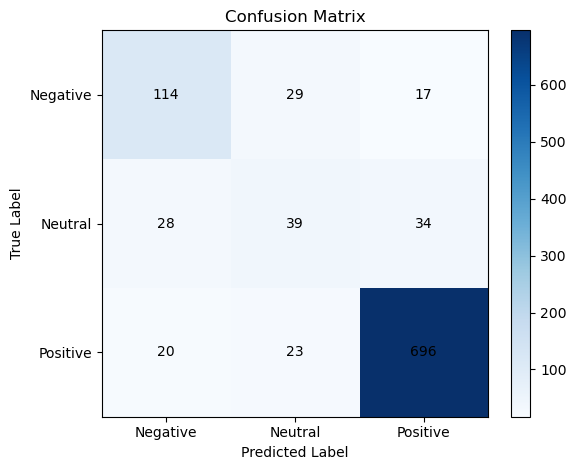

In [14]:
# Plot the confusion matrix 
cm = confusion_matrix(test_df["sentiment_id"], y_pred)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")        
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [15]:
joblib.dump(pipeline, "lr_tfidf_experiment6.pkl")

['lr_tfidf_experiment6.pkl']